In [8]:
import datetime
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob

import galsim
from galsim import roman
from galsim import InterpolatedImage

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo

(45, 45)


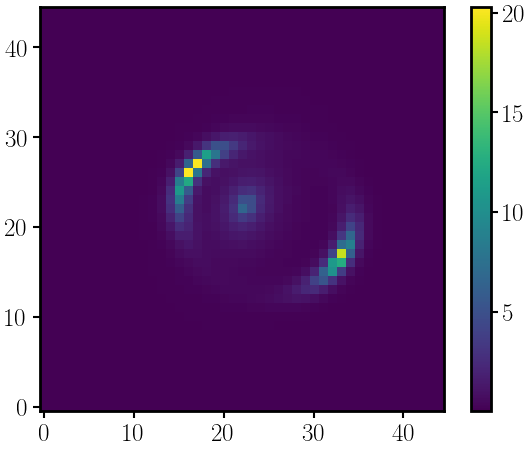

In [9]:
band = 'F106'
filter_name = 'Y106'

lens = SampleStrongLens()
model = lens.get_array(num_pix=45, side=4.95, band=band)

print(model.shape)
pixel_side, _ = model.shape

plot.plot(model, colorbar=True)

In [10]:
# get flux
lens_flux_cps = lens.lens_light_model_class.total_flux([lens.kwargs_lens_light_amp_dict[band]])[0]
source_flux_cps = lens.source_model_class.total_flux([lens.kwargs_source_amp_dict[band]])[0]
total_flux_cps = source_flux_cps + lens_flux_cps

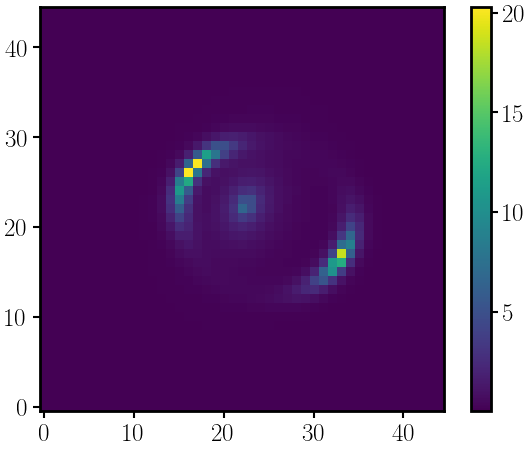

In [11]:
image = galsim.Image(model, scale=0.11)
plot.plot(image.array, colorbar=True)

In [12]:
interp = galsim.InterpolatedImage(image, flux=total_flux_cps)